# CellSAM introduction
This notebook will guide a user through using CellSAM. More details on CellSAM can be obtained at the preprint: https://www.biorxiv.org/content/10.1101/2023.11.17.567630v3

CellSAM exposes two main API functions. For biologists, we recommend using `segment_cellular_image`, which accepts an image, automatically downloads weights, and returns a mask. `segment_cellular_image` has several additional functions (e.g., postprocessing, normalization, boundary removal), but can often be used out of the box. For machine learning practitioners or users with more esoteric usecases, we provide direct access to the model and weights through a `get_model` function.

For more information or additional assistance, feel free to get in touch. Please email the following addresses:
```
ulisrael@caltech.edu
mmarks@caltech.edu
rdilip@caltech.edu
qli2@caltech.edu
```

In [18]:
from cellSAM import segment_cellular_image, get_model

In [19]:
import numpy as np
import torch
from scipy.ndimage import binary_dilation
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Finding all cells using CellSAM
First, let's see how one can directly use the CellSAM module to predict all the masks in a cell. We'll load a sample image and pass it through CellSAM. When bounding boxes aren't provided, the CellFinder module automatically finds bounding boxes for all the cells. Notice we specify a GPU device. Although CellSAM will still work on a CPU, it will be quite slow if there are a large number of cells. 

In [20]:
!wget https://storage.googleapis.com/cellsam-data/yeaz.npy

--2024-03-26 15:19:07--  https://storage.googleapis.com/cellsam-data/yeaz.npy
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.189.27, 142.251.40.59, 142.250.72.155, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.189.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3145856 (3.0M) [application/octet-stream]
Saving to: ‘yeaz.npy.4’

yeaz.npy.4          100%[===================>]   3.00M  --.-KB/s    in 0.04s   

2024-03-26 15:19:07 (71.4 MB/s) - ‘yeaz.npy.4’ saved [3145856/3145856]



In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

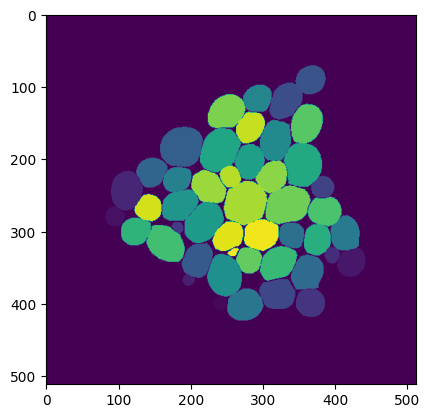

In [30]:
img = np.load("yeaz.npy") # H, W, C
mask, embedding, bounding_boxes = segment_cellular_image(img, device=str(device))
plt.imshow(mask)

# Prompting CellSAM
What if we want to label specific cells? This is a natural outcome if we use CellSAM as a data engine to accelerate labeling for new morphologies or cell types. Let's pick out a specific box and show how we can segment only that cell. We'll use the model directly.

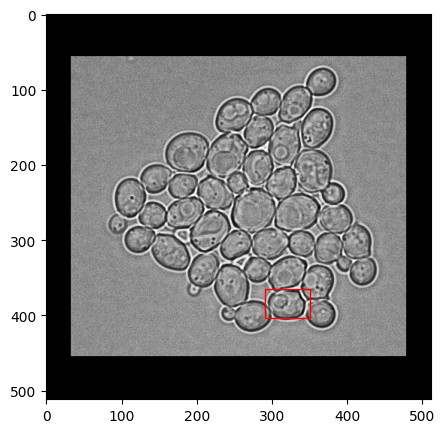

In [31]:
# Here's the cell we want to segment!
box = [290, 365, 60, 38] # x, y, w, h

rect = patches.Rectangle(
    (box[0], box[1]), box[2], box[3], linewidth=1, edgecolor='r', facecolor='none'
)

plt.figure(figsize=(5, 5))
plt.imshow(img[:, :, -1], cmap='gray')
plt.gca().add_patch(rect)


In [32]:
model = get_model()

# We can pass the bounding boxes to the model prediction function
x1, y1, w, h = box
x2, y2 = x1 + w, y1 + h
scale_x, scale_y = (1024 / img.shape[1]), (1024 / img.shape[0])
x1, x2, y1, y2 = scale_x * x1, scale_x * x2, scale_y * y1, scale_y * y2

pred_mask = model.predict(
    img[None].transpose((0,3,1,2)),
    boxes_per_heatmap=[[[x1, x2, y1, y2]]]
)[0]

Now, let's visualize the predicted mask. We'll superimpose the mask as an edge onto our image to see it more clearly

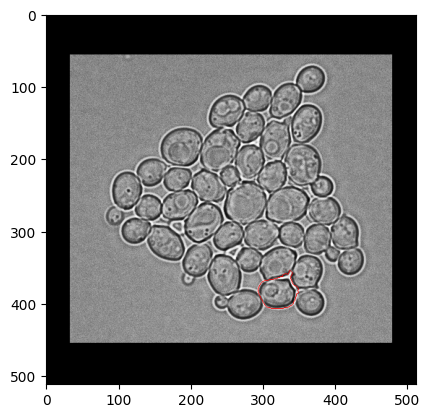

In [10]:
dilated_mask = binary_dilation(pred_mask)
edges = dilated_mask ^ pred_mask

full_img = np.array([img[:, :, -1]] * 3).transpose((1,2,0))
r, c = np.where(np.isclose(1.0, edges))
full_img[r, c] = [1,0,0]
plt.imshow(full_img)

And that's it! For more info on CellSAM, feel free to reach out or check out the official deployment at https://cellsam.deepcell.org.